In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

2024-03-08 12:41:15.258197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## First try

In [3]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-01,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,NaN,...,0,0,0,0,0,1,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2020-03-01,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,4848745.0,0.0,0.0,415989.793,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2024-01-07,103436829.0,NaN,0.0,305763.910,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2024-01-14,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0


In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [5]:
df=process(df)
df=normalize(df)
df.shape

(20209, 68)

In [6]:
grouped = df.groupby('date')
sequences = []
targets = []


for _, group in grouped:
    deaths = group['new_deaths'].values
    for i in range(len(deaths) - 13):
        sequences.append(deaths[i:i+13])
        targets.append(deaths[i+13])

sequences = np.array(sequences)
targets = np.array(targets)

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

X_train = np.reshape(X_train, (X_train.shape[0], 13, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 13, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 13, 1))

In [8]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [9]:
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

2024-03-07 13:02:24.943852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
    x=X_train, y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val))


Epoch 1/100
330/330 [==============================] - 12s 17ms/step - loss: 837.0373 - val_loss: 781.4502
Epoch 2/100
330/330 [==============================] - 4s 11ms/step - loss: 808.3300 - val_loss: 759.2367
Epoch 3/100
330/330 [==============================] - 5s 16ms/step - loss: 786.2673 - val_loss: 738.5192
Epoch 4/100
330/330 [==============================] - 4s 12ms/step - loss: 767.3349 - val_loss: 722.4079
Epoch 5/100
330/330 [==============================] - 4s 13ms/step - loss: 751.9047 - val_loss: 708.4913
Epoch 6/100
330/330 [==============================] - 4s 12ms/step - loss: 735.2761 - val_loss: 692.7084
Epoch 7/100
330/330 [==============================] - 5s 14ms/step - loss: 721.1561 - val_loss: 678.9679
Epoch 8/100
330/330 [==============================] - 5s 15ms/step - loss: 707.5049 - val_loss: 666.4419
Epoch 9/100
330/330 [==============================] - 6s 17ms/step - loss: 695.0566 - val_loss: 657.3184
Epoch 10/100
330/330 [=======================

330/330 [==============================] - 2s 6ms/step


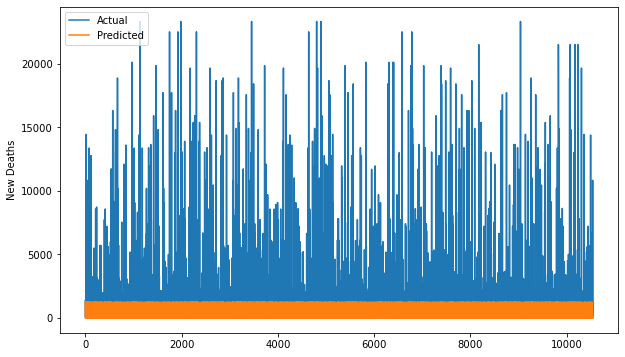

In [11]:
train_pred = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [13]:
test_pred = model.predict(X_test)


110/110 [==============================] - 0s 3ms/step


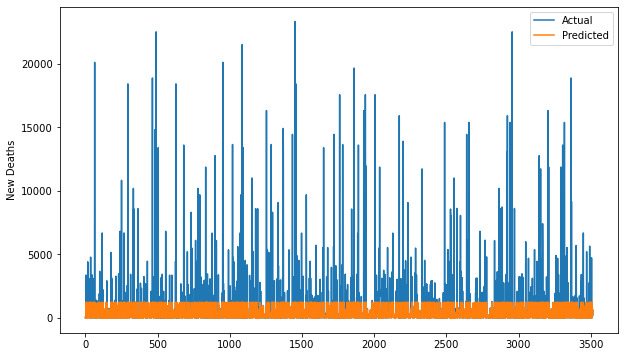

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [14]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_pred, y_test, y_train = y_train)

In [15]:
mase

0.3548758955483503

# trying again

In [29]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

,location,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,...,continent_Asia,continent_Europe,continent_North America,continent_South America,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-01,France,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0
2020-03-01,Ireland,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,...,0,1,0,0,0,0,0,1,0,0
2020-03-01,Czechia,NaN,0.0,0.0,NaN,0.000,0.000,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0
2020-03-01,Israel,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,Belgium,4848745.0,0.0,0.0,415989.793,0.000,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1
2024-01-07,United States,103436829.0,NaN,0.0,305763.910,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,1
2024-01-14,Estonia,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1


In [27]:
df[['new_deaths']]

,new_deaths
date,
2020-03-01,0.0
2020-03-01,0.0
2020-03-01,0.0
2020-03-01,0.0
2020-03-01,0.0
...,...
2024-01-14,0.0
2024-01-14,0.0
2024-01-14,1.0


In [32]:
def process(df):
    locations = df['location']
    lag1df = df.drop(columns=['location']).shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    lag1df['location'] = locations
    cols = lag1df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    lag1df = lag1df[cols]
    df = df[['new_deaths']].join(lag1df)
    
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths' and col != 'location':
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [33]:
df=process(df)
df=normalize(df)
df.shape

(20209, 59)

In [34]:
country_groups = df.groupby('location')

sorted_data = {}
for country, data in country_groups:
    sorted_data[country] = data.sort_values('date')

sequence_length = 13
sequences = []
targets = []
for country, data in sorted_data.items():
    for i in range(len(data) - sequence_length):
        sequences.append(data['new_deaths'].values[i:i+sequence_length])
        targets.append(data['new_deaths'].values[i+sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

In [36]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [37]:
inputs = keras.layers.Input(shape=(13, 1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          validation_split=0.1)


Epoch 1/100
452/452 [==============================] - 7s 17ms/step - loss: 845.9655 - val_loss: 741.9638
Epoch 2/100
452/452 [==============================] - 7s 15ms/step - loss: 845.2639 - val_loss: 741.9826
Epoch 3/100
452/452 [==============================] - 8s 18ms/step - loss: 845.1136 - val_loss: 741.4998
Epoch 4/100
452/452 [==============================] - 7s 16ms/step - loss: 844.2026 - val_loss: 739.9973
Epoch 5/100
452/452 [==============================] - 8s 17ms/step - loss: 843.3309 - val_loss: 741.7485
Epoch 6/100
452/452 [==============================] - 9s 20ms/step - loss: 844.8558 - val_loss: 740.6425
Epoch 7/100
452/452 [==============================] - 10s 21ms/step - loss: 844.6775 - val_loss: 740.8239
Epoch 8/100
452/452 [==============================] - 9s 21ms/step - loss: 843.8878 - val_loss: 739.9153
Epoch 9/100
452/452 [==============================] - 9s 20ms/step - loss: 843.2610 - val_loss: 740.2830
Epoch 10/100
452/452 [=======================

In [40]:
predictions = model.predict(X_test.reshape((-1, sequence_length, 1)))

mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(y_test, predictions, y_train = y_train)

126/126 [==============================] - 1s 3ms/step


In [41]:
mase

0.5450183871077023

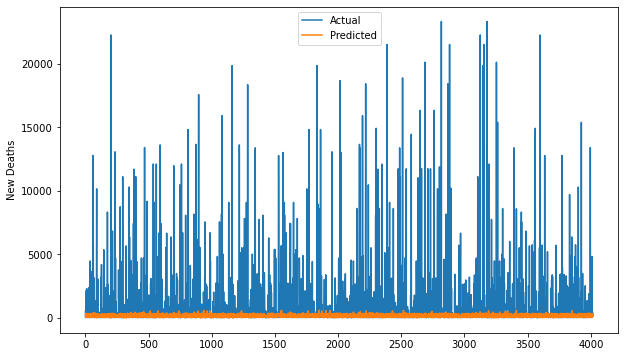

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Trying a Third Time

In [44]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [46]:
def process(df):
    locations = df['location']
    lag1df = df.drop(columns=['location']).shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    lag1df['location'] = locations
    cols = lag1df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    lag1df = lag1df[cols]
    df = df[['new_deaths']].join(lag1df)
    
    return df.fillna(0)

df = process(df)

In [48]:
grouped = df.groupby('location')
sequences = []
targets = []


for _, group in grouped:
    deaths = group['new_deaths'].values
    for i in range(len(deaths) - 13):
        sequences.append(deaths[i:i+13])
        targets.append(deaths[i+13])

sequences = np.array(sequences)
targets = np.array(targets)

In [49]:
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

X_train = np.reshape(X_train, (X_train.shape[0], 13, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 13, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 13, 1))

In [55]:
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], 1))

In [59]:
X_val_scaled = scaler.transform(X_val.reshape((X_val.shape[0], -1)))

X_val_scaled = X_val_scaled.reshape((X_val.shape[0], X_val.shape[1], 1))

In [56]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [57]:
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(
    x=X_train_scaled, y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val_scaled, y_val))

Epoch 1/100
377/377 [==============================] - 9s 11ms/step - loss: 855.6391 - val_loss: 813.6252
Epoch 2/100
377/377 [==============================] - 5s 13ms/step - loss: 852.1760 - val_loss: 813.7153
Epoch 3/100
377/377 [==============================] - 6s 16ms/step - loss: 852.1628 - val_loss: 813.6745
Epoch 4/100
377/377 [==============================] - 7s 19ms/step - loss: 852.1626 - val_loss: 813.7756
Epoch 5/100
377/377 [==============================] - 5s 13ms/step - loss: 852.1577 - val_loss: 813.7692
Epoch 6/100
377/377 [==============================] - 7s 17ms/step - loss: 852.1639 - val_loss: 813.7750
Epoch 7/100
377/377 [==============================] - 8s 23ms/step - loss: 852.1568 - val_loss: 813.6627
Epoch 8/100
377/377 [==============================] - 7s 19ms/step - loss: 852.1601 - val_loss: 813.6934
Epoch 9/100
377/377 [==============================] - 9s 23ms/step - loss: 852.1644 - val_loss: 813.6856
Epoch 10/100
377/377 [========================

377/377 [==============================] - 2s 3ms/step


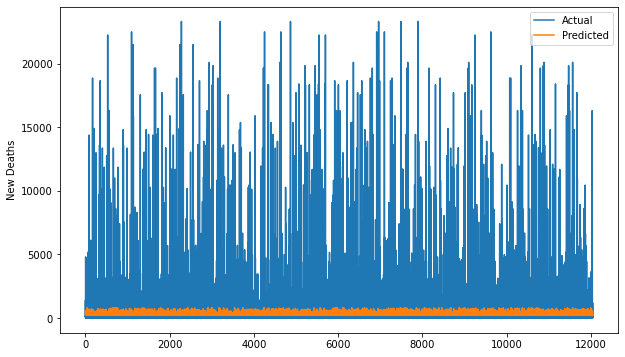

In [61]:
train_pred = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

126/126 [==============================] - 0s 2ms/step


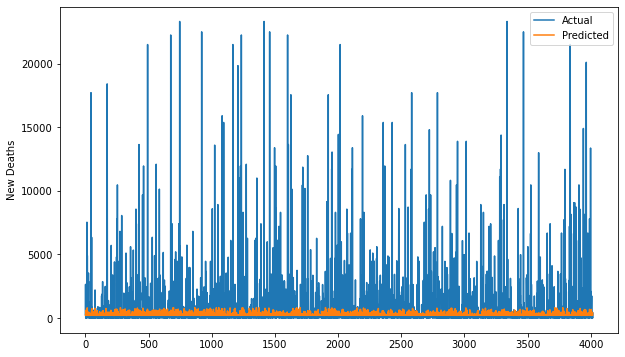

In [62]:
test_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [63]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_pred, y_test, y_train = y_train)
mase

0.6005343518840915

# Pre-Processing

In [ ]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mase', 'rsq'])

In [8]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [9]:
def get_country(data):
    data = data.drop(columns=['location'])
    return data

def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

# Attempt 1

In [10]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=32, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium


2024-03-08 12:55:56.795881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
5/5 [==============================] - 4s 226ms/step - loss: 143.4749 - val_loss: 77.6365
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 142.1108 - val_loss: 76.2666
Epoch 3/100
5/5 [==============================] - 0s 33ms/step - loss: 140.7703 - val_loss: 74.9132
Epoch 4/100
5/5 [==============================] - 0s 37ms/step - loss: 139.4431 - val_loss: 73.3955
Epoch 5/100
5/5 [==============================] - 0s 39ms/step - loss: 138.0509 - val_loss: 72.2518
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 137.0330 - val_loss: 71.2988
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 136.1980 - val_loss: 70.3280
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 135.2699 - val_loss: 69.3847
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 134.4263 - val_loss: 68.4615
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 133.5661 - val_lo

5/5 [==============================] - 0s 24ms/step


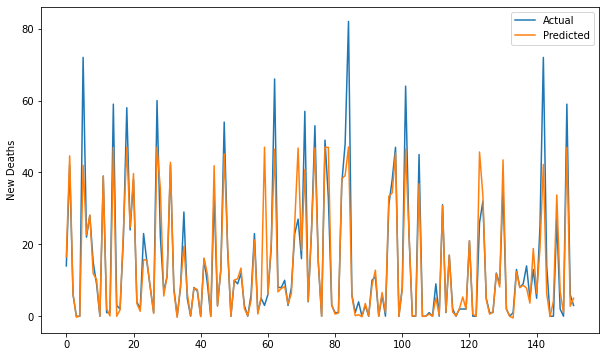

In [19]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2/2 [==============================] - 0s 13ms/step


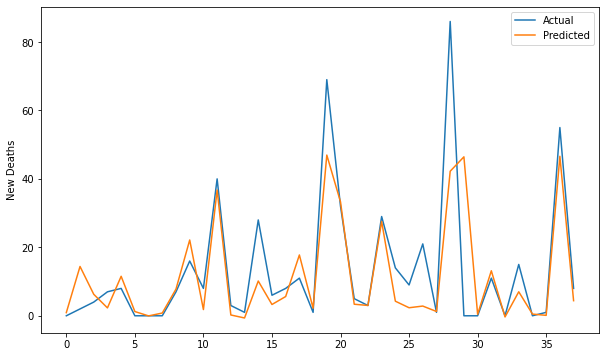

In [24]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [29]:
mae = mean_absolute_error(flat_test_pred, y_test)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
r2 = r2_score(flat_test_pred, y_test)
new_row = {'model': '1', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

0.40780628538290775

# Attempt 2

In [30]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=16, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium
Epoch 1/100
9/9 [==============================] - 6s 142ms/step - loss: 144.4868 - val_loss: 79.6490
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 144.2036 - val_loss: 79.3244
Epoch 3/100
9/9 [==============================] - 0s 23ms/step - loss: 143.8708 - val_loss: 78.9113
Epoch 4/100
9/9 [==============================] - 0s 24ms/step - loss: 143.4747 - val_loss: 78.4932
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 143.0702 - val_loss: 78.0802
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 142.6973 - val_loss: 77.6029
Epoch 7/100
9/9 [==============================] - 0s 27ms/step - loss: 142.2197 - val_loss: 76.9012
Epoch 8/100
9/9 [==============================] - 0s 28ms/step - loss: 141.5268 - val_loss: 76.0631
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 140.7317 - val_loss: 75.2449
Epoch 10/100
9/9 [==============================] - 0s 30ms/ste

5/5 [==============================] - 1s 3ms/step


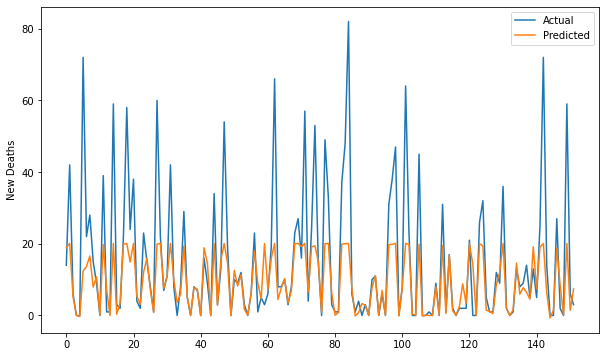

In [31]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [ ]:
len()

2/2 [==============================] - 0s 4ms/step


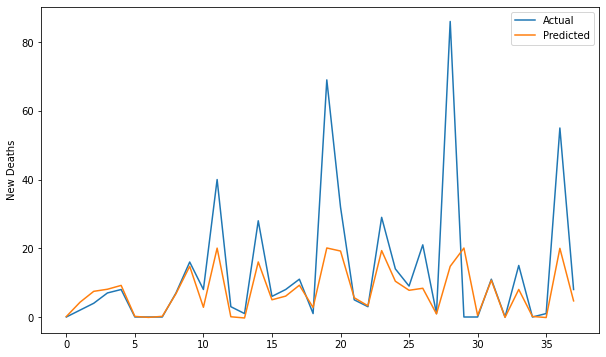

In [32]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [33]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
mase

0.46124660779927074

## Attempt 3